# Imports

In [1]:
import nltk
nltk.download('punkt')
import pandas as pd
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn import svm
from sklearn.linear_model import SGDClassifier

from joblib import dump, load
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import itertools
import numpy as np

# fix random seed for reproducibility
seed = 42  # change to Thuya's

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\conta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import os

from sklearn import preprocessing

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, losses

## Data Loading

In [3]:
file_path = 'data/fulltrain.csv'

colnames=['Label', 'Text'] 
df = pd.read_csv(file_path, names=colnames, header=None)

## Split

In [4]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_valid_index in split.split(df, df.Label):
    train_set = df.iloc[train_index]
    test_valid_set = df.iloc[test_valid_index]

split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for test_index, valid_index in split2.split(test_valid_set, test_valid_set.Label):
    test_set = test_valid_set.iloc[test_index]
    valid_set = test_valid_set.iloc[valid_index]

In [5]:
train_set['Label'].value_counts()

3    10722
1     8428
4     5997
2     4165
Name: Label, dtype: int64

In [6]:
# in case you need to access separately

X_train = train_set['Text']
y_train = train_set['Label']

X_val = valid_set['Text']
y_val = valid_set['Label']

X_test = test_set['Text']
y_test = test_set['Label']

# Model
 * Multinomial Naive Bayes
 * Linear Support Vector Classifer
 * Logistic Regression
 * Simple Neural Network
 * LSTM

## Steps

Preprocessing 

Feature engineering (tfidf)

Model training

Prediction

Evaluation

Model save / load

# Multinomial Naive Bayes Classifier

# Model Training

In [7]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

def label_smoothing(y_true, y_pred):
    """ smooth the label to boost the accuracy e.g. [0, 1, 0] -> [0.1, 0.8, 0.1] """
    return losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

def build_model(vocab_size, embedding_dim, embedding_matrix):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim,
                               weights=[embedding_matrix],
                               input_length=MAXLEN,
                               trainable=True))
    model.add(layers.GlobalAvgPool1D())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))
    model.compile(optimizer=optimizers.Adamax(learning_rate=0.001),
                  loss=label_smoothing,
                  metrics=['accuracy'])
    return model

In [8]:
tokenizer = Tokenizer(num_words=7000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [9]:
MAXLEN = 170

X_train = pad_sequences(X_train, padding='post', maxlen=MAXLEN)
X_val = pad_sequences(X_val, padding='post', maxlen=MAXLEN)
X_test = pad_sequences(X_test, padding='post', maxlen=MAXLEN)

In [10]:
embedding_dim = 200
embedding_weight_file = os.path.join("glove.6B", "glove.6B.200d.txt")
embedding_matrix = create_embedding_matrix(embedding_weight_file, tokenizer.word_index, embedding_dim)

In [11]:
encoder = preprocessing.LabelEncoder()
encoded_y_train = encoder.fit_transform(y_train)
encoded_y_val = encoder.transform(y_val)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = to_categorical(encoded_y_train)
dummy_y_val = to_categorical(encoded_y_val)

In [17]:
vocab_size = len(tokenizer.word_index) + 1

model = build_model(vocab_size, embedding_dim, embedding_matrix)
history = model.fit(X_train, dummy_y_train,
          epochs=40,
          verbose=True,
          validation_data=(X_val, dummy_y_val),
          batch_size=512)

Train on 29312 samples, validate on 9771 samples
Epoch 1/40
29312/29312 [==============================] - 8s 276us/sample - loss: 1.2595 - accuracy: 0.4892 - val_loss: 1.1320 - val_accuracy: 0.6543
Epoch 2/40
29312/29312 [==============================] - 7s 233us/sample - loss: 1.0333 - accuracy: 0.6938 - val_loss: 0.9304 - val_accuracy: 0.7347
Epoch 3/40
29312/29312 [==============================] - 7s 239us/sample - loss: 0.8596 - accuracy: 0.7678 - val_loss: 0.7922 - val_accuracy: 0.7992
Epoch 4/40
29312/29312 [==============================] - 7s 227us/sample - loss: 0.7481 - accuracy: 0.8195 - val_loss: 0.7094 - val_accuracy: 0.8435
Epoch 5/40
29312/29312 [==============================] - 7s 242us/sample - loss: 0.6798 - accuracy: 0.8542 - val_loss: 0.6561 - val_accuracy: 0.8645
Epoch 6/40
29312/29312 [==============================] - 7s 239us/sample - loss: 0.6329 - accuracy: 0.8753 - val_loss: 0.6182 - val_accuracy: 0.8849
Epoch 7/40
29312/29312 [===========================

In [18]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

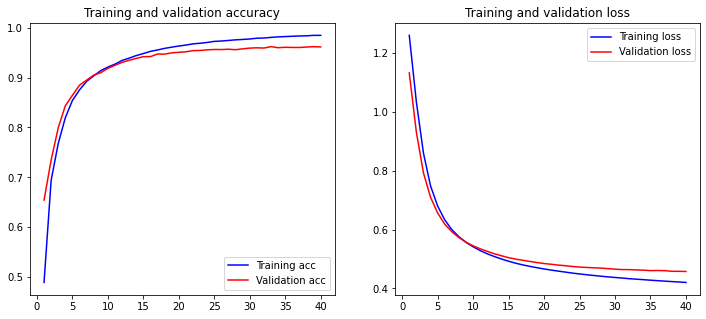

In [19]:
plot_history(history)

## Model Evaluation

f1 score


In [23]:
y_pred = model.predict(X_test).argmax(axis=1) + 1

In [24]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.95      0.97      0.96      2809
     class 1       0.97      0.96      0.97      1389
     class 2       0.96      0.98      0.97      3574
     class 3       0.96      0.90      0.93      1999

    accuracy                           0.96      9771
   macro avg       0.96      0.95      0.96      9771
weighted avg       0.96      0.96      0.96      9771



In [25]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[2717   11   42   39]
 [   6 1337   37    9]
 [  18   21 3515   20]
 [ 114   10   67 1808]]


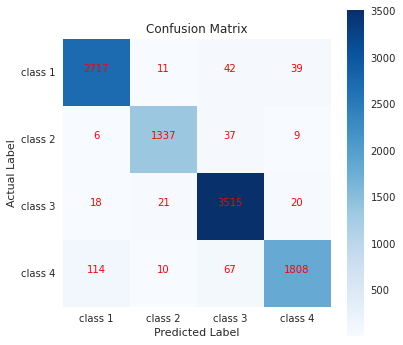

In [26]:
with plt.style.context(('ggplot', 'seaborn')):
    fig = plt.figure(figsize=(6,6), num=1)
    plt.imshow(conf_mat, interpolation='nearest',cmap= plt.cm.Blues )
    plt.xticks([0,1,2,3],['class 1', 'class 2', 'class 3', 'class 4'])
    plt.yticks([0,1,2,3],['class 1', 'class 2', 'class 3', 'class 4'])
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
                plt.text(j, i,conf_mat[i, j], horizontalalignment="center",color="red")
    plt.grid(None)
    plt.title('Confusion Matrix')
    plt.colorbar();

auc-roc


In [31]:
y_test_pred_softmax = model.predict_proba(X_test)

In [32]:
from sklearn.metrics import roc_curve, auc

In [33]:
from sklearn.preprocessing import label_binarize

Y_test = label_binarize(y_test, classes=[1, 2, 3, 4])

In [34]:
n_classes = len(df['Label'].unique())

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_test_pred_softmax[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_test_pred_softmax.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

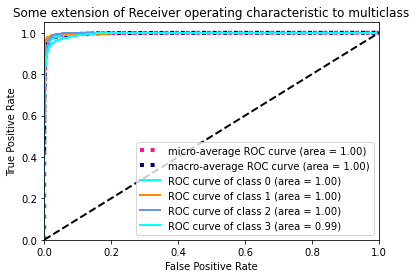

In [35]:
from itertools import cycle
lw = 2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(Y_test, y_test_pred_softmax, multi_class='ovr')
print(f"ROC_AUC score is {roc_auc}")